# Model Evaluation

## **Lecture Topics**
*  Motivation for model evaluation
*  Model evaluation procedure
*  Model evaluation metrics:
 *  Accuracy
 *  Confusion matrix
 *  Precision, Recall, F1
 *  Receiver Operating Characteristic (ROC) Curves
 *  Area Under the Curve (AUC)


*This tutorial is derived from Data School's Machine Learning with scikit-learn tutorial. *

## **What's the deal with model evaluation?**

 *   We need a way to choose between different model types, tuning parameters, and features
 *   Model evaluation enables us to estimate how well a model will generalize to out-of-sample data
 *   A model evaluation metric (or many!) required to quantify the model performance


## **Model evaluation procedure:**
1. Split the dataset into a TRAINING set and TESTING set.  Put the testing data set aside and do not use it for any part of model training.
2. Leave out part of the TRAINING set as a VALIDATION set.
3. Train the model on only the TRAINING data set.
4. Evaluate model performance on the VALIDATION set.
5. Repeat steps 2+ as necessary.
6. Only once the model has been finalized, should you evaluate on the left-out TESTING set.

### **Classification Data Set**
In this notebook we will work with the popular [PIMA Indians diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database/version/1). The goal is to predict whether or not a given female patient will contract diabetes based on certain diagnostic measurements. This is a ***binary*** classification problem. An outcome value of 0 indicates that the patient does not have diabetes, while an outcome of 1 indicates that the patient does have diabetes. 



In [101]:
# import packages
!pip install graphviz 
!apt-get install graphviz

import graphviz 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.38.0-16ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [102]:
# Read in the data
data_url = 'https://raw.githubusercontent.com/BeaverWorksMedlytics/datasets/master/diabetes.csv'
data = pd.read_csv(data_url)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


The columns correspond to the following features:
*  **Pregnancies:** Number of times pregnant
* **Glucose: ** Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* **BloodPressure: ** Diastolic blood pressure (mm Hg)
* **SkinThickness: ** Triceps skin fold thickness (mm)
* **Insulin: ** 2-Hour serum insulin (mu U/ml)
* **BMI: ** Body mass index (weight in kg/(height in m)^2)
* **DiabetesPedigreeFunction: ** Diabetes pedigree function
* **Age: ** Age (years)
* **Outcome: ** Whether or not the woman has diabetes (0 or 1)

In [0]:
# define features (X) and labels (y)
feature_names = ['Pregnancies','Glucose','BloodPressure','SkinThickness','BMI','Age']
X = data.loc[:, feature_names]

# y is a vector, hence we use dot to access 'label'
y = data.Outcome

### Split the data set into training, validation, and test sets

In [0]:
from sklearn.model_selection import train_test_split

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=0)

# further split X and y into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,random_state=0)

### Train a model on the training data only

In [105]:
# train a logistic regression model on the training set
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# instantiate model
model = DecisionTreeClassifier(max_depth=4,random_state=0)

# fit model
model.fit(X_train, y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

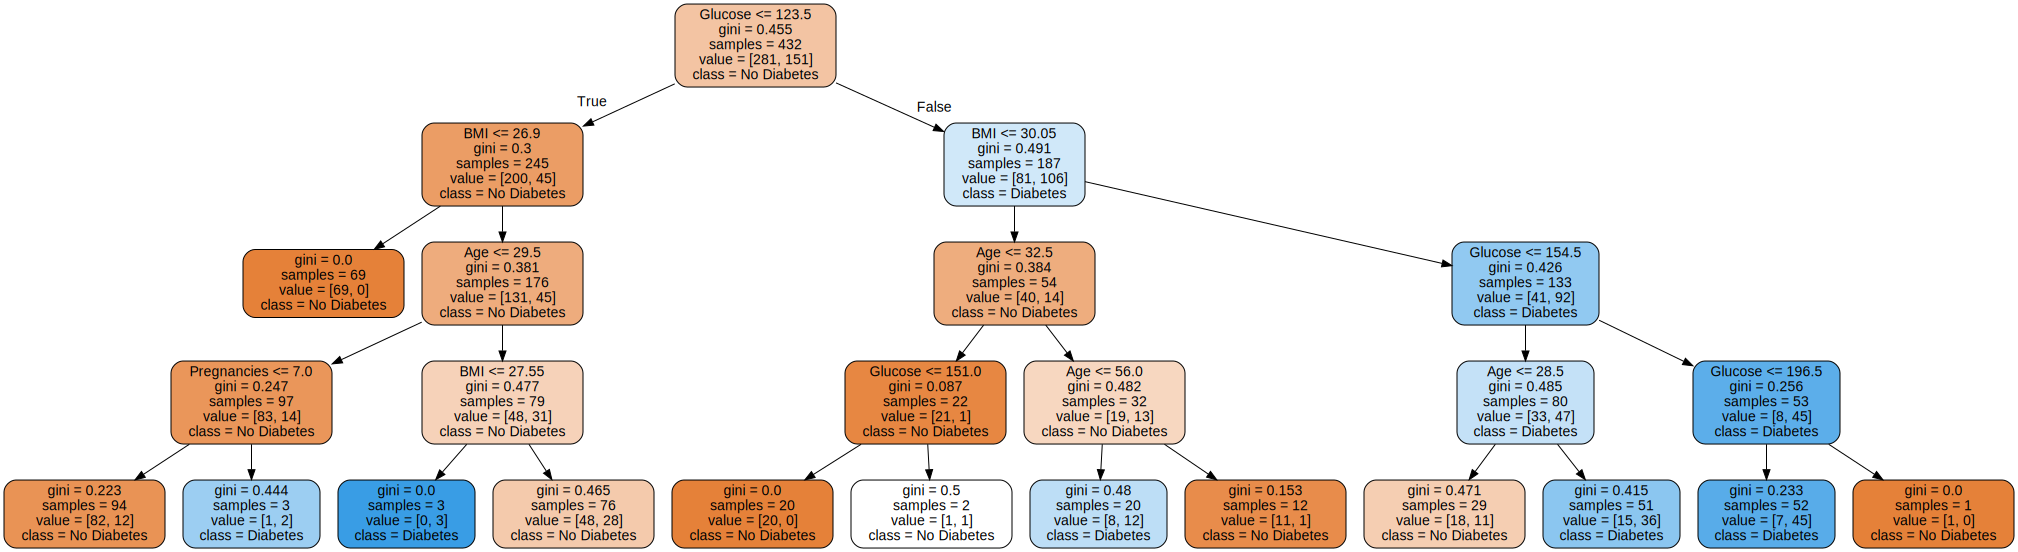

In [106]:
# visualize the decision tree
dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=feature_names,  
                         class_names=['No Diabetes','Diabetes'],  
                         filled=True, rounded=True,
                         max_depth=4) 

graph = graphviz.Source(dot_data)  
graph 

### Evaluate the model on the validation data set

For now, we will use the model to predict the binary classes of our validation data.  
Later we'll look at the case where our model outputs a probability over class labels.

In [0]:
# make class predictions for the training validation set
y_val_predict = model.predict(X_val)
y_train_predict = model.predict(X_train)

In [142]:
# calculate model training accuracy
from sklearn import metrics
print('Training Accuracy:   {:01.3f}'.format(metrics.accuracy_score(y_train, y_train_predict)))

# calculate model validation accuracy
print('Validation Accuracy: {:01.3f}'.format(metrics.accuracy_score(y_val, y_val_predict)))

Training Accuracy:   0.806
Validation Accuracy: 0.778


Notice that our **training accuracy** is higher than our **validation accuracy**.  This is fairly typical, as  machine learning algorithms have a tendency to overfit the training data.  When choosing a model, it's a good idea to tune it such that you are not overfitting too much.


<img src="https://raw.githubusercontent.com/BeaverWorksMedlytics/datasets/master/fittings.jpg" width="600">

Okay, so our decision tree got ~78% validation accuracy.  But how do we know if that's a "good" accuracy?  Let's look at the simple case where we have a model that always predicts the most common class.  How well would that do?

In [109]:
# examine the class distribution of the validation set (using a Pandas Series method)
y_val.value_counts(normalize=True)

0    0.618056
1    0.381944
Name: Outcome, dtype: float64

This means that a trivial model that always predicts 0 would be right ~62% of the time.  So our decision tree seems to be doing something.

Now let's investigate the errors our model is making by looking at the confusion matrix:

<img src="https://raw.githubusercontent.com/BeaverWorksMedlytics/datasets/master/confusion matrix 2.png" width="250">

In [110]:
# Use sklearn to make the confusion matrix
print('Confusion Matrix:')
labels = [0,1]
cm = metrics.confusion_matrix(y_val, y_val_predict, labels)
print(cm)

# Normalized confusion matrix
print('\nNormalized Confusion Matrix:')
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_norm)

Confusion Matrix:
[[79 10]
 [22 33]]

Normalized Confusion Matrix:
[[0.88764045 0.11235955]
 [0.4        0.6       ]]


In [111]:
# Or you can use pandas -- it's a little nicer to look at
pd.crosstab(y_val, y_val_predict, rownames=['True'], colnames=['Predicted'], margins=True)


Predicted,0,1,All
True,,,
0,79,10,89
1,22,33,55
All,101,43,144


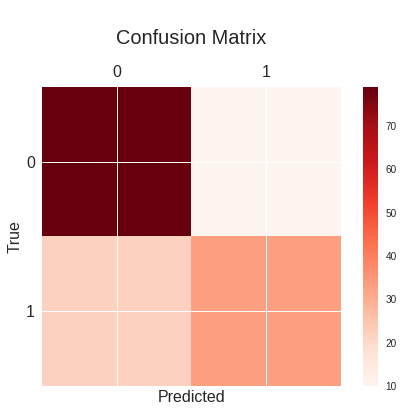

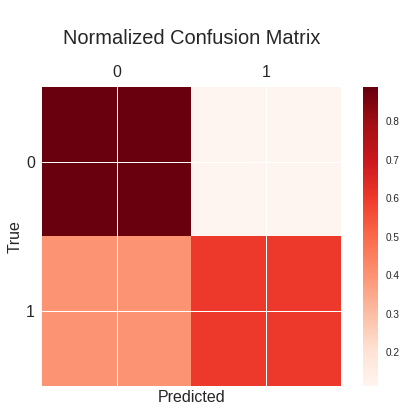

In [112]:
# Visualize the confusion matrix
def plot_cmatrix(cm,labels,title='Confusion Matrix'):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm,cmap='Reds')
  plt.title('\n'+title+'\n', fontsize=20)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels, fontsize=16)
  ax.set_yticklabels([''] + labels, fontsize=16)
  plt.xlabel('Predicted', fontsize=16)
  plt.ylabel('True', fontsize=16)
  plt.show()
  
plot_cmatrix(cm,labels)
plot_cmatrix(cm_norm,labels,title='Normalized Confusion Matrix')

You can even make a confusion matrix for the multi-class problem!  Check out this toy example:

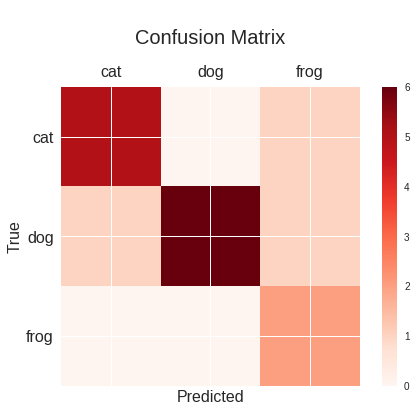

In [114]:
y2=pd.Series(['dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'frog', 'dog', 'dog', 'cat', 'frog'])
y2pred=pd.Series(['dog', 'cat', 'dog', 'dog', 'cat', 'frog', 'cat', 'cat', 'dog', 'cat', 'dog', 'frog', 'frog', 'dog', 'cat', 'frog'])

animal_labels=['cat','dog','frog']
cm = metrics.confusion_matrix(y2,y2pred, animal_labels)
plot_cmatrix(cm,animal_labels)

### More Metrics
There are several useful metrics that are derived from the confusion matrix:
* sensitivity, **recall**, hit rate, or true positive rate (TPR) : $ \mathrm {TPR} ={\frac {\mathrm {TP} }{P}}={\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FN} }}$
 
* **precision** or positive predictive value (PPV) : $ \mathrm {PPV} ={\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FP} }}$

* specificity or true negative rate (TNR) : $\mathrm {TNR} ={\frac {\mathrm {TN} }{N}}={\frac {\mathrm {TN} }{\mathrm {TN} +\mathrm {FP} }}$

* miss rate or false negative rate (FNR) : $ \mathrm {FNR} ={\frac {\mathrm {FN} }{P}}={\frac {\mathrm {FN} }{\mathrm {FN} +\mathrm {TP} }}=1-\mathrm {TPR}$

* fall-out or false positive rate (FPR) : $\mathrm {FPR} ={\frac {\mathrm {FP} }{N}}={\frac {\mathrm {FP} }{\mathrm {FP} +\mathrm {TN} }}=1-\mathrm {TNR} $

* accuracy (ACC) : $\mathrm {ACC} ={\frac {\mathrm {TP} +\mathrm {TN} }{P+N}}={\frac {\mathrm {TP} +\mathrm {TN} }{\mathrm {TP} +\mathrm {TN} +\mathrm {FP} +\mathrm {FN} }}$

The F1 score is the harmonic mean of precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
 * F1 score: $F_{1}=2\cdot {\frac {\mathrm {PPV} \cdot \mathrm {TPR} }{\mathrm {PPV} +\mathrm {TPR} }}={\frac {2\mathrm {TP} }{2\mathrm {TP} +\mathrm {FP} +\mathrm {FN} }}$



In [123]:
print('Precision: {:01.3f}'.format(metrics.precision_score(y_val,y_val_predict)))
print('Recall:    {:01.3f}'.format(metrics.accuracy_score(y_val,y_val_predict)))
print('F1 score:  {:01.3f}'.format(metrics.f1_score(y_val,y_val_predict)))
     

Precision: 0.767
Recall:    0.778
F1 score:  0.673


## Evaluate the model on the validation data set (part 2)

Up to now, we've simply been evaluating our model's ability to predict the correct class.  But in many (most) cases, our model actually outputs a *probability* or *certainty* over the class labels.  Let's take a look at the output of our decision tree.

In [124]:
# Predict class label probabilities
labels = [0,1]
y_val_prob = model.predict_proba(X_val,labels)

# Output predicted and true values for the first validation point
print('Probabilities:\n',y_val_prob[0])
print('\nTrue Value:\n',y_val.values[0])

Probabilities:
 [0.13461538 0.86538462]

True Value:
 1


Notice that the decision tree predicts that there is a ~87% probability that this data point belongs to class label 1.  But this doesn't necessarily mean we *have* to label the data point as class 1.  For example, we may decide to say that we need to be 90% confident that the data belongs to class 1, otherwise we say it belongs to class 0.  The predicted class will depend on where we threshold our decision boundary.  


Choosing a threshold is not always as straighforward as choosing the label with the greatest probability.  Particularly in cases where your data set is very biased or there is a greater penalty for false positives than false negatives (and vice-versa), it is often desirable to evaluate the model over all thresholds.  This is where the **Receiver Operating Characteristic (ROC) curve** comes in!


The ROC curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.  The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.


The **area under the curve (AUC) ** is often used as a more robust and descriptive metric of a classification model's performance, where an AUC of 1 is "perfect" and an AUC of 0 means that the classifier is no better than random.

In [0]:
# Calculate the FPR and TPR at varying thresholds (assume label 1 is the "postive" class)
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_val_prob[:,1])

# Calculate the area under the ROC curve
roc_auc = metrics.auc(fpr, tpr)

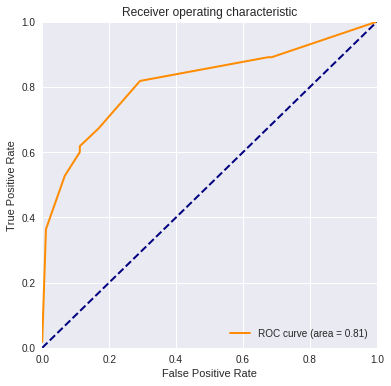

In [143]:
# Plot the ROC curve
plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()